In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("CustomerChurnPrediction").getOrCreate()

# Load the dataset
data_path = "Churn_Modelling.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Show the schema of the dataframe
df.printSchema()

# Show the first few rows of the dataframe
df.show(5)


root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+----

         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000     

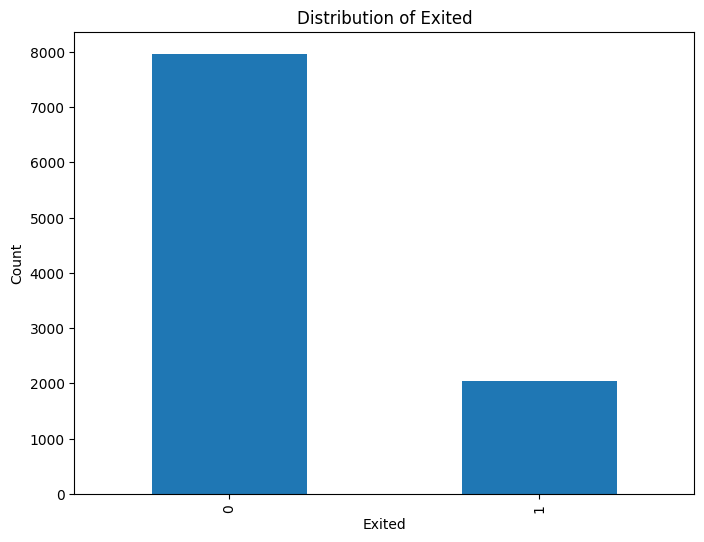

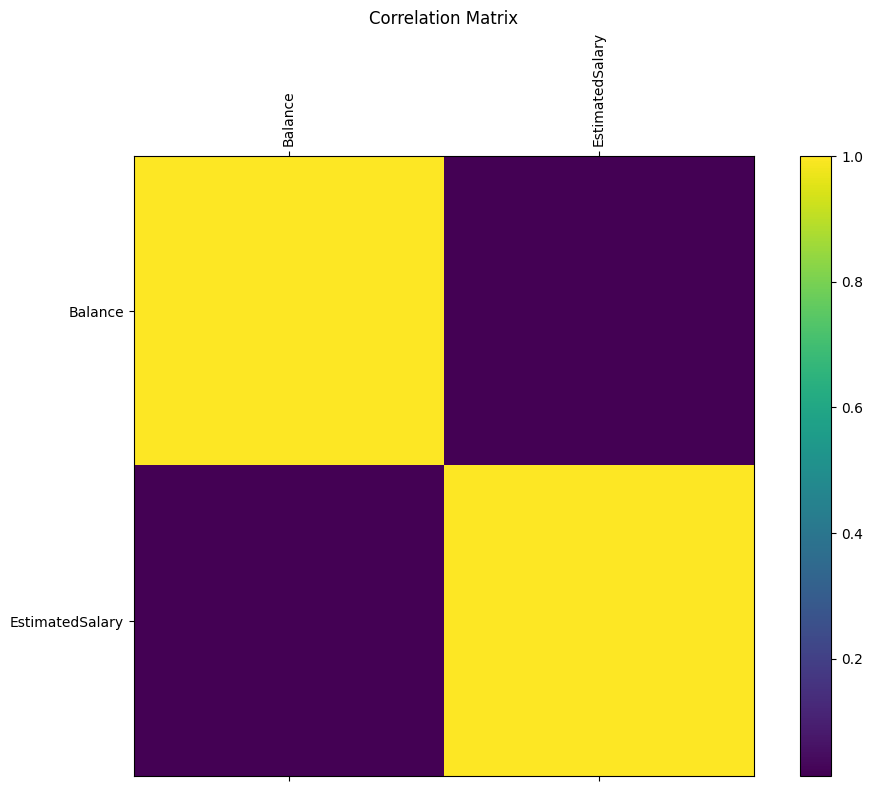

In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas dataframe for visualization
pandas_df = df.toPandas()

# Display basic statistics
print(pandas_df.describe())

# Visualize the distribution of the target variable 'Exited'
plt.figure(figsize=(8, 6))
pandas_df['Exited'].value_counts().plot(kind='bar')
plt.title('Distribution of Exited')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.show()

# Drop non-numeric columns for correlation matrix
numeric_df = pandas_df.select_dtypes(include=['float64', 'int64'])

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()


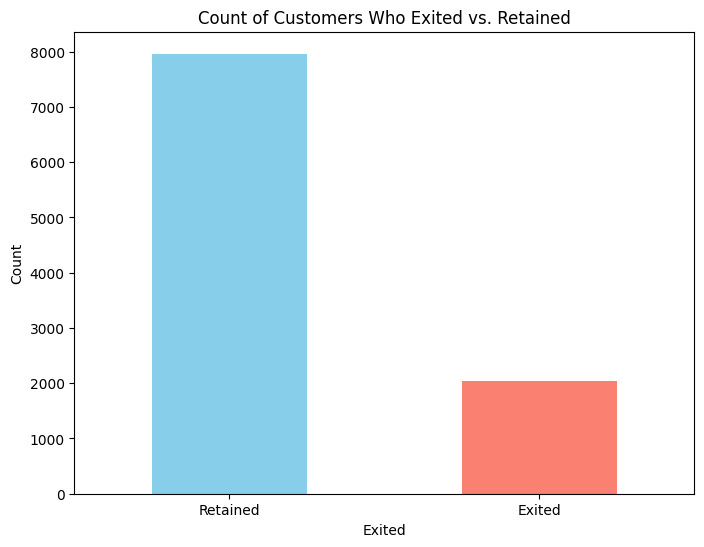

In [5]:
# Visualize the count of customers who exited vs. retained
plt.figure(figsize=(8, 6))
pandas_df['Exited'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Customers Who Exited vs. Retained')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Retained', 'Exited'], rotation=0)
plt.show()


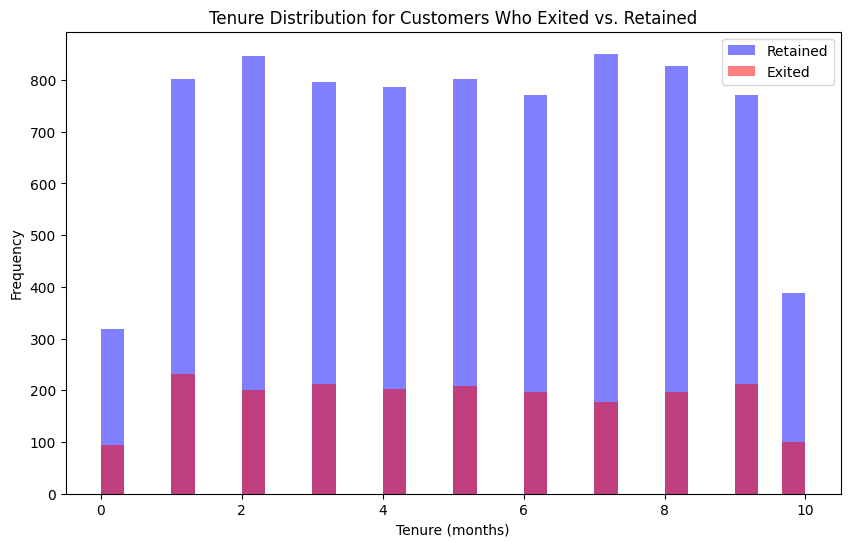

In [6]:
# Tenure distribution for exited vs. retained customers
plt.figure(figsize=(10, 6))
pandas_df[pandas_df['Exited'] == 0]['Tenure'].plot(kind='hist', alpha=0.5, color='blue', bins=30, label='Retained')
pandas_df[pandas_df['Exited'] == 1]['Tenure'].plot(kind='hist', alpha=0.5, color='red', bins=30, label='Exited')
plt.title('Tenure Distribution for Customers Who Exited vs. Retained')
plt.xlabel('Tenure (months)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


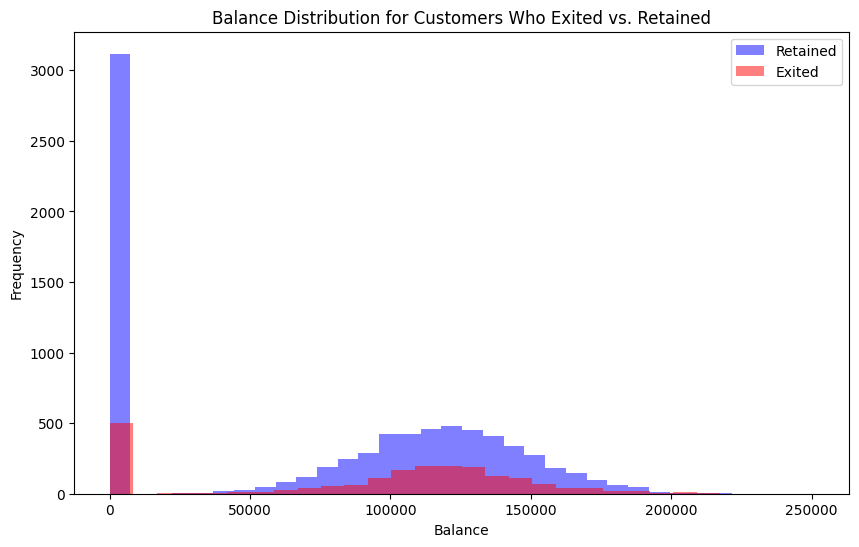

In [7]:
# Balance distribution for exited vs. retained customers
plt.figure(figsize=(10, 6))
pandas_df[pandas_df['Exited'] == 0]['Balance'].plot(kind='hist', alpha=0.5, color='blue', bins=30, label='Retained')
pandas_df[pandas_df['Exited'] == 1]['Balance'].plot(kind='hist', alpha=0.5, color='red', bins=30, label='Exited')
plt.title('Balance Distribution for Customers Who Exited vs. Retained')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


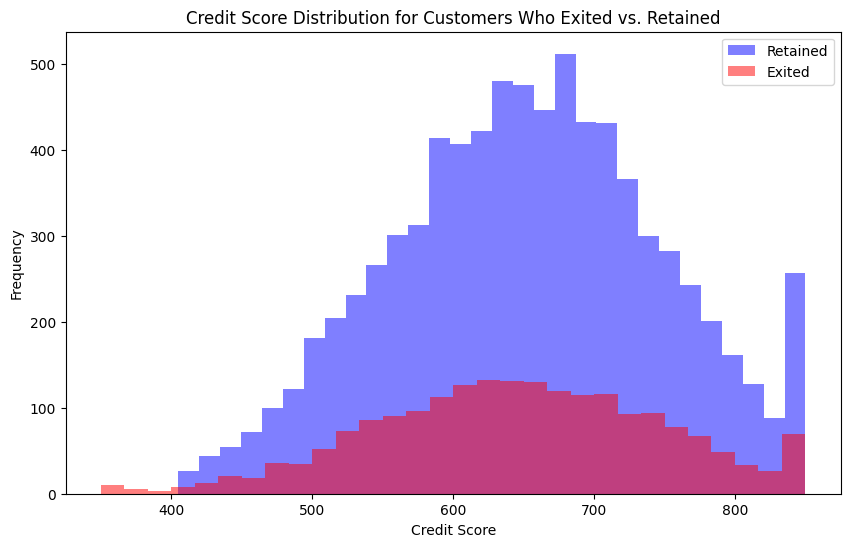

In [8]:
# Credit score distribution for exited vs. retained customers
plt.figure(figsize=(10, 6))
pandas_df[pandas_df['Exited'] == 0]['CreditScore'].plot(kind='hist', alpha=0.5, color='blue', bins=30, label='Retained')
pandas_df[pandas_df['Exited'] == 1]['CreditScore'].plot(kind='hist', alpha=0.5, color='red', bins=30, label='Exited')
plt.title('Credit Score Distribution for Customers Who Exited vs. Retained')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [9]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import col

# Convert categorical columns to numerical using StringIndexer
categorical_columns = ['Geography', 'Gender']
indexers = [StringIndexer(inputCol=column, outputCol=column + "Index").fit(df) for column in categorical_columns]

for indexer in indexers:
    df = indexer.transform(df)

# Drop the original categorical columns and unwanted columns
df = df.drop('RowNumber', 'CustomerId', 'Surname', 'Geography', 'Gender')

# Assemble feature columns into a feature vector
feature_columns = df.columns[:-1]  # All columns except 'Exited'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Select the final dataset with features and label
final_df = df.select("features", col("Exited").alias("label"))
final_df.show(5)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[619.0,42.0,2.0,0...|    1|
|[608.0,41.0,1.0,8...|    0|
|[502.0,42.0,8.0,1...|    1|
|(10,[0,1,2,4,7],[...|    0|
|[850.0,43.0,2.0,1...|    0|
+--------------------+-----+
only showing top 5 rows



In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Split the data into training and test sets
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=1234)

# Initialize the logistic regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Define a parameter grid for cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the cross-validator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="label"),
                          numFolds=5)

# Train the model
cv_model = crossval.fit(train_df)

# Make predictions on the test set
predictions = cv_model.transform(test_df)
predictions.select("features", "label", "prediction").show(5)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label")
accuracy = evaluator.evaluate(predictions)
print(f"Test Set Accuracy = {accuracy}")


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(10,[0,1,2,4,7],[...|    0|       0.0|
|(10,[0,1,2,4,7],[...|    0|       0.0|
|(10,[0,1,2,4,7],[...|    0|       0.0|
|(10,[0,1,2,4,7],[...|    0|       0.0|
|(10,[0,1,2,4,7],[...|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

Test Set Accuracy = 1.0


Test Set AUC = 1.0


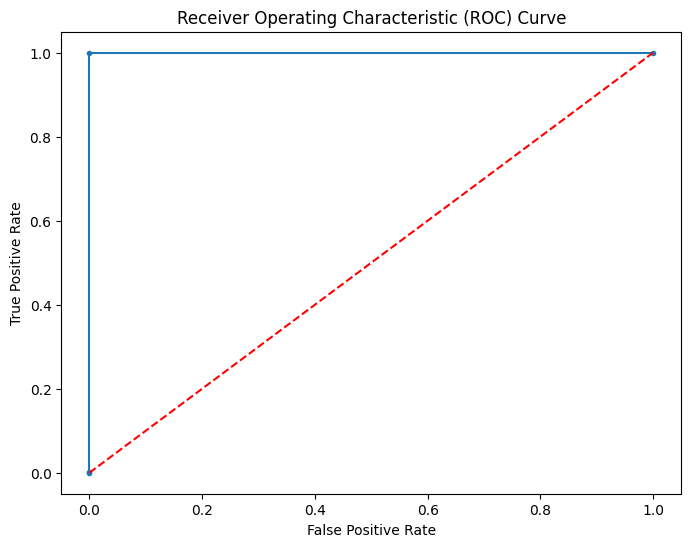

In [12]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Compute raw scores on the test set
predictions = cv_model.transform(test_df)

# Instantiate evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Compute the AUC
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Test Set AUC = {auc}")

# Extract the probability column
probabilities = predictions.select('probability').collect()
probabilities = [prob[0][1] for prob in probabilities]

# Extract the true labels
true_labels = predictions.select('label').collect()
true_labels = [label[0] for label in true_labels]

# Compute ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(true_labels, probabilities)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


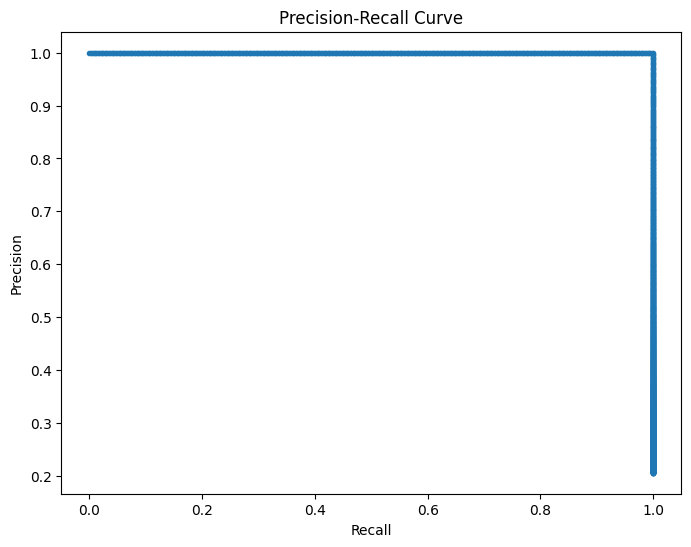

In [13]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(true_labels, probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


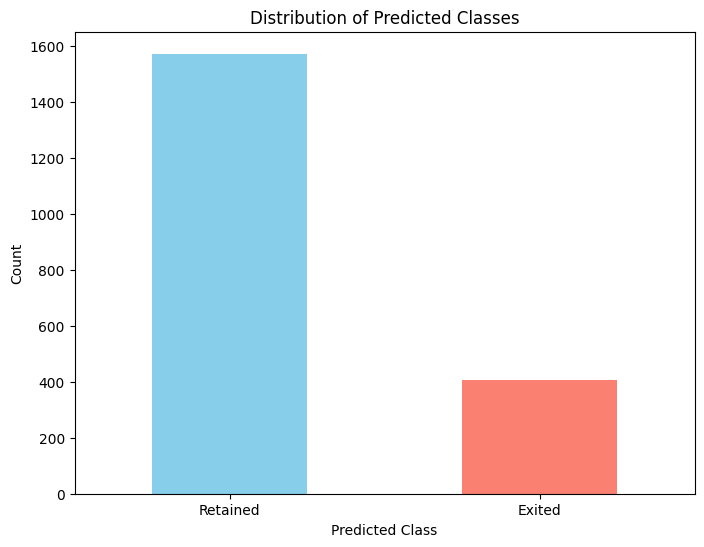

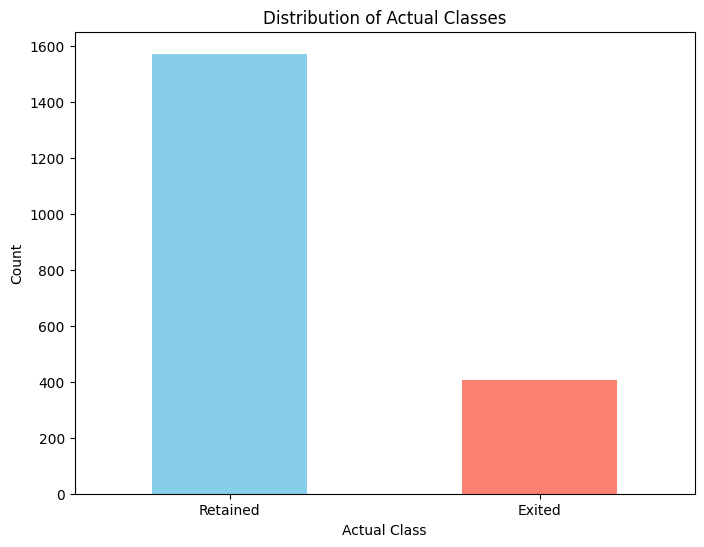

In [14]:
# Convert predictions to Pandas dataframe for visualization
pandas_predictions = predictions.select("prediction", "label").toPandas()

# Plot the distribution of predicted classes
plt.figure(figsize=(8, 6))
pandas_predictions['prediction'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Retained', 'Exited'], rotation=0)
plt.show()

# Plot the distribution of actual classes
plt.figure(figsize=(8, 6))
pandas_predictions['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Actual Classes')
plt.xlabel('Actual Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Retained', 'Exited'], rotation=0)
plt.show()


In [15]:
model_path = "output"
cv_model.write().overwrite().save(model_path)


In [13]:
# import os
# os.environ["HADOOP_HOME"] = "C:/spark-3.5.2-bin-hadoop3"  # Đường dẫn đến thư mục cài Hadoop
# os.environ["PATH"] += os.pathsep + "C:/spark-3.5.2-bin-hadoop3/bin"
